In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# https://pystan.readthedocs.io/en/latest/api.html
# http://tjo.hatenablog.com/entry/2014/05/01/190346

In [2]:
model="""
data {
  int<lower=0> N;
  int<lower=0> D;
  matrix[N,D] x;
  int<lower=0,upper=1> y[N];
}
parameters {
  real alpha;
  vector[D] beta;
  real r[N];
  real<lower=0> s;
}
model {
  for (n in 1:N)
    y[n] ~ bernoulli(inv_logit(alpha + x[n] * beta + r[n]));
  alpha ~ uniform(0, 1.0e+4);
  for (d in 1:D)
    beta[d] ~ normal(0, 1.0e+4);
  for (n in 1:N)
    r[n] ~ normal(0, 1/(s*s));
  s ~ uniform(0, 1.0e+4);
}
"""

In [17]:
#custom
model="""
data {
  int<lower=0> N;
  int<lower=0> D;
  //matrix[N,D] X;
  vector[D] X[N];
  int<lower=0,upper=1> Y[N];
}
parameters {
  real alpha;
  vector[D] beta;
  vector[N] r;
  real<lower=0> s;
}
model {
  s ~ uniform(0, 1.0e+4);
  r ~ normal(0, 1 / (s * s));
  alpha ~ normal(0, 1.0e+4);
  beta ~ normal(0, 1.0e+4);
  for (n in 1:N)
    Y[n] ~ bernoulli(inv_logit(alpha + X[n] .* beta + r[n]));
}
"""

# extract data from DB to DataFrame
- ここでDataFrameにデータ入れる
- user_id, c_i1, c_i2, c_i3,,,

In [4]:
datum = np.loadtxt("women.tsv", delimiter="\t", usecols=(1, 2), skiprows=1)
weights = np.transpose(datum)[0]
heights = np.transpose(datum)[1]
y = np.array([0,0,0,0,0,0,0,1,1,1,1,1,1,1,1])

In [5]:
datum.shape[1]

2

In [6]:
datum

array([[  58.,  115.],
       [  59.,  117.],
       [  60.,  120.],
       [  61.,  123.],
       [  62.,  126.],
       [  63.,  129.],
       [  64.,  132.],
       [  65.,  135.],
       [  66.,  139.],
       [  67.,  142.],
       [  68.,  146.],
       [  69.,  150.],
       [  70.,  154.],
       [  71.,  159.],
       [  72.,  164.]])

In [18]:
fit = pystan.stan(model_code=model, data=dict(N=datum.shape[0], D=datum.shape[1], X=datum, Y=y, chains=4), iter=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3077d34ff7281279a787fd9c3a11696e NOW.


In [20]:
fit

Inference for Stan model: anon_model_3077d34ff7281279a787fd9c3a11696e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   -1.0e4  2655.3 4599.2 -2.1e4 -1.3e4 -1.0e4  -5770  -1131      3   2.46
beta[0] 155.97   41.17  71.31  17.58  89.53 157.38 195.21  321.8      3   2.46
beta[1]  75.35   19.88  34.44   8.47  43.36  76.01  94.07 155.57      3   2.47
r[0]      0.03    0.29   5.46 -11.37  -0.01-5.1e-6   0.01   12.7    346   1.02
r[1]   -2.4e-3    0.21   6.57 -12.69  -0.01-1.4e-6   0.01  13.81   1010    1.0
r[2]     -0.18    0.25   5.84 -11.99  -0.01-7.0e-7   0.01  11.07    558    1.0
r[3]     -0.38    0.23   6.82 -15.62  -0.02-3.9e-6 9.5e-3   11.7    872   1.01
r[4]     -0.08    0.22   5.74 -11.12  -0.01 1.1e-6   0.01  12.21    708    1.0
r[5]     -0.21    0.17   5.94 -11.06  -0.02-9.6e-6   0.01  10.92   1220    1.0
r[6]     -0.14    0.17 

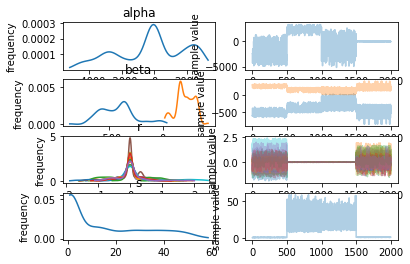

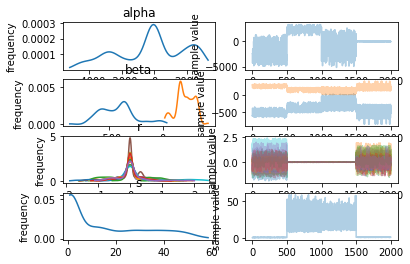

In [14]:
fit.plot()

In [12]:
samples = fit.extract(permuted=True)
alpha = np.mean(samples["alpha"])
beta = np.mean(samples["beta"])

In [13]:
samples

OrderedDict([('alpha',
              array([-82.22820262, -92.38969827, -83.37650134, ..., -90.50577089,
                     -81.99767927, -88.54256003])),
             ('beta',
              array([ 3.3617893 ,  3.5202511 ,  3.38053096, ...,  3.49791975,
                      3.36787773,  3.47229179])),
             ('sigma',
              array([ 1.88958229,  1.46308603,  1.4933092 , ...,  1.09260552,
                      1.5696753 ,  1.55110954])),
             ('lp__',
              array([-13.86421223, -13.0418492 , -13.16953399, ..., -14.2712301 ,
                     -12.93044326, -13.01552621]))])

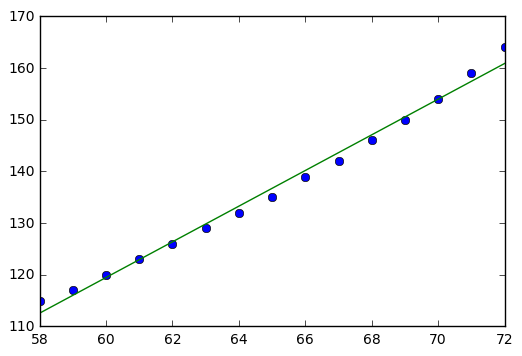

In [14]:
plt.plot(weights, heights, "o")
plt.plot(weights, alpha + beta * weights)
plt.show()